In [2]:
import sys 
import numpy as np # linear algebra
from scipy.stats import randint
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph 
import seaborn as sns # used for plot interactive graph. 
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.model_selection import KFold # use for cross validation
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score

## for Deep-learing:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout

In [3]:
df = pd.read_csv('household_power_consumption.txt', sep=';', 
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')

In [4]:
droping_list_all=[]
for j in range(0,7):
    if not df.iloc[:, j].notnull().all():
        droping_list_all.append(j)        
        #print(df.iloc[:,j].unique())
droping_list_all

[0, 1, 2, 3, 4, 5, 6]

In [5]:
for j in range(0,7):        
        df.iloc[:,j]=df.iloc[:,j].fillna(df.iloc[:,j].mean())

In [6]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [7]:
df_resample = df.resample('h').mean() 
df_resample.shape

(34589, 7)

In [8]:
values = df_resample.values 

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled, 1, 1)

reframed.drop(reframed.columns[[8,9,10,11,12,13]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.636816   0.295738   0.337945   0.631157        0.0   0.011366   
2   0.545045   0.103358   0.335501   0.541487        0.0   0.144652   
3   0.509006   0.110073   0.283802   0.502152        0.0   0.030869   
4   0.488550   0.096987   0.315987   0.481110        0.0   0.000000   
5   0.455597   0.099010   0.434417   0.449904        0.0   0.008973   

   var7(t-1)   var1(t)  
1   0.782418  0.545045  
2   0.782676  0.509006  
3   0.774169  0.488550  
4   0.778809  0.455597  
5   0.798917  0.322555  


In [9]:
# split into train and test sets
values = reframed.values

n_train_time = 365*24
train = values[:n_train_time, :]
test = values[n_train_time:, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 
# We reshaped the input into the 3D format as expected by LSTMs, namely [samples, timesteps, features].

(8760, 1, 7) (8760,) (25828, 1, 7) (25828,)


Train on 8760 samples, validate on 25828 samples
Epoch 1/20
 - 1s - loss: 0.0188 - val_loss: 0.0114
Epoch 2/20
 - 0s - loss: 0.0121 - val_loss: 0.0102
Epoch 3/20
 - 1s - loss: 0.0111 - val_loss: 0.0094
Epoch 4/20
 - 1s - loss: 0.0108 - val_loss: 0.0093
Epoch 5/20
 - 1s - loss: 0.0106 - val_loss: 0.0094
Epoch 6/20
 - 1s - loss: 0.0106 - val_loss: 0.0093
Epoch 7/20
 - 1s - loss: 0.0105 - val_loss: 0.0093
Epoch 8/20
 - 0s - loss: 0.0105 - val_loss: 0.0094
Epoch 9/20
 - 1s - loss: 0.0105 - val_loss: 0.0094
Epoch 10/20
 - 1s - loss: 0.0105 - val_loss: 0.0093
Epoch 11/20
 - 0s - loss: 0.0104 - val_loss: 0.0094
Epoch 12/20
 - 1s - loss: 0.0104 - val_loss: 0.0094
Epoch 13/20
 - 1s - loss: 0.0104 - val_loss: 0.0094
Epoch 14/20
 - 1s - loss: 0.0104 - val_loss: 0.0093
Epoch 15/20
 - 1s - loss: 0.0104 - val_loss: 0.0094
Epoch 16/20
 - 1s - loss: 0.0104 - val_loss: 0.0093
Epoch 17/20
 - 0s - loss: 0.0105 - val_loss: 0.0093
Epoch 18/20
 - 1s - loss: 0.0104 - val_loss: 0.0093
Epoch 19/20
 - 1s - loss

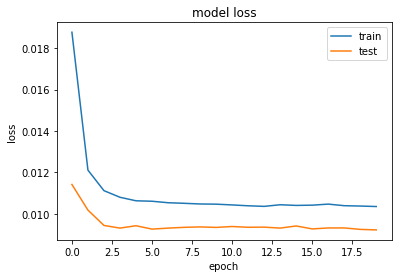

Test RMSE: 0.618


In [10]:
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
#    model.add(LSTM(70))
#    model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')



# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=70, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], 7))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

In [11]:
import joblib
joblib.dump(model, "power_lstm.joblib")
model.save("prediction_model.h5")